# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [10]:
### Replace each question mark with the appropriate value.

n_train = X_train.shape[0]
# TODO: Number of testing examples.
n_test = X_test.shape[0]
# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])
# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

7 Speed limit (100km/h)


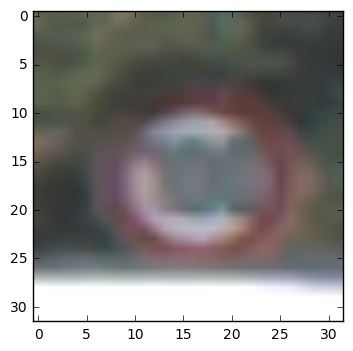

In [16]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
# Visualizations will be shown in the notebook.
%matplotlib inline

signs = dict()

with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']


index = random.randint(0, len(X_train))
image = X_train[index]
plt.imshow(image)
print(y_train[index], signs[str(y_train[index])])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
17 No entry


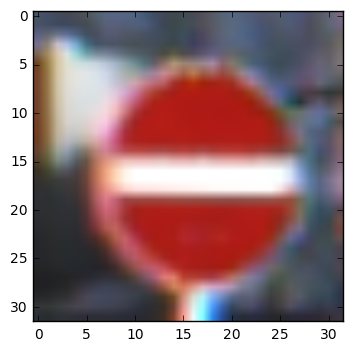

Training...

EPOCH 1 ...
Validation Accuracy = 0.691

EPOCH 2 ...
Validation Accuracy = 0.870

EPOCH 3 ...
Validation Accuracy = 0.901

EPOCH 4 ...
Validation Accuracy = 0.896

EPOCH 5 ...
Validation Accuracy = 0.930

EPOCH 6 ...
Validation Accuracy = 0.944

EPOCH 7 ...
Validation Accuracy = 0.946

EPOCH 8 ...
Validation Accuracy = 0.939

EPOCH 9 ...
Validation Accuracy = 0.943

EPOCH 10 ...
Validation Accuracy = 0.964

EPOCH 11 ...
Validation Accuracy = 0.950

EPOCH 12 ...
Validation Accuracy = 0.958

EPOCH 13 ...
Validation Accuracy = 0.955

EPOCH 14 ...
Validation Accuracy = 0.961

EPOCH 15 ...
Validation Accuracy = 0.969

Model saved
Test Accuracy = 0.909


In [1]:
# Load pickled data
import pickle
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.contrib.layers import flatten

# Visualizations will be shown in the notebook.
# %matplotlib inline

lr = tf.placeholder(tf.float32)
#Image enhancement factor
enhancement_factor = 2
#Number of channels in images - 3 - color, 1 - monochrome
img_channels = 3

# Pre-process images
def featureNormalize(features, meanDiv, stdDiv):
    normFeatures = features.astype('float32')
    normFeatures -= meanDiv
    normFeatures /= stdDiv
    return normFeatures

def LeNet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Weights for the convolution layer 1 match filter 5x5 channels 1 # of filters 6
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, img_channels, 6), mean=mu, stddev=sigma))
    # Bias for layer 1 - # of filters
    b1 = tf.Variable(tf.zeros(6))
    # Convolution layer 1 = xW1 with stride 1,1,1,1 and padding + b1
    C1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
    # Activation.
    # Convolution layer 1 output tensor
    C1 = tf.nn.relu(C1)
    # Pooling. Input = 28x28x6. Output = 14x14x6. Pooling 2x2
    C1 = tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    C2 = tf.nn.conv2d(C1, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
    # TODO: Activation.
    C2 = tf.nn.relu(C2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    C2 = tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    FC0 = flatten(C2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    FC1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    FC1_b = tf.Variable(tf.zeros(120))
    FC1 = tf.matmul(FC0, FC1_W) + FC1_b
    # Activation.
    FC1 = tf.nn.relu(FC1)
    # FC1_D = tf.nn.dropout(FC1, 1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    FC2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    FC2_b = tf.Variable(tf.zeros(84))
    FC2 = tf.matmul(FC1, FC2_W) + FC2_b
    # Activation.
    FC2 = tf.nn.relu(FC2)
    # Dropout
    # FC2 = tf.nn.dropout(FC2, 1)

    # Layer 5: Fully Connected. Input = 84. Output = 84.
    FC3_W = tf.Variable(tf.truncated_normal(shape=(84, 84), mean=mu, stddev=sigma))
    FC3_b = tf.Variable(tf.zeros(84))
    FC3 = tf.matmul(FC2, FC3_W) + FC3_b
    # Activation.
    FC3 = tf.nn.relu(FC3)
    # FC3 = tf.nn.dropout(FC3, 1)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    FC4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    FC4_b = tf.Variable(tf.zeros(43))
    FC4_Logits = tf.matmul(FC3, FC4_W) + FC4_b
    return FC4_Logits


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']

# X_train = np.empty((X_train_COLOR.shape[0], X_train_COLOR.shape[1], X_train_COLOR.shape[2], img_channels), dtype='uint8')
# for idx in range(0, X_train_COLOR.shape[0]):
#     X_train[idx] = ImagePreprocess(X_train_COLOR[idx])

X_test, y_test = test['features'], test['labels']
# X_test = np.empty((X_test_COLOR.shape[0], X_test_COLOR.shape[1], X_test_COLOR.shape[2], img_channels), dtype='uint8')
# for idx in range(0, X_test_COLOR.shape[0]):
#     X_test[idx] = ImagePreprocess(X_test_COLOR[idx])

#Perform feature normalization
mean = np.mean(X_test)
std = np.std(X_test)
X_train = featureNormalize(X_train, mean, std)
X_test = featureNormalize(X_test, mean, std)


X_train, X_validation, y_train, y_validation = \
train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### Replace each question mark with the appropriate value.
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]
# TODO: Number of testing examples.
n_test = X_test.shape[0]
# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])
# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
# Reading sign designations
signs = dict()
with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']

index = random.randint(0, len(X_train))
image = X_train[index]
print(y_train[index], signs[str(y_train[index])])
plt.imshow(image)
plt.show()


X_train, y_train = shuffle(X_train, y_train)

EPOCHS = 15
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, img_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

#Use learning rate decay
max_learn_rate = 0.001
min_learn_rate = 0.0005
decay_speed = 20.0

logits = LeNet(x)
Y_ = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(Y_, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            learning_rate = min_learn_rate + (max_learn_rate - min_learn_rate) * math.exp(-i/decay_speed)
            # if (offset == 0):
            #     print ("Learing rate[", offset, "]=", learning_rate)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, lr: learning_rate})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, '.\lenet-signs')
    print("Model saved")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))




### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
'''
Considered generating more data by rotating the images but realized that the same images under different angles change the meaning
of each image. Skipped the step to focus more on accuracy and image preprocessing.
I have created 2 convolutional and 2 pooling layers as well as 4 fully connected layers.
I experimented with the dropout but it didn't seem to have any effect on the outcome most likely due to the insufficient data set.
I tried learning rate decay and that proved to be more promising with the accuracy on the validation set hitting 98.3 and on test 
reaching 92.2 
Feature normalization had possitive effect, while image grayscaling didn't seem to improve the prediction.
I split the test data in 80/20 between test and validation tests. I used the validation test to measure accuracy of the model.
All sets underwent feature normalization on mean std of the test set.

The directed acyclical graph of the flow is shown below
'''
import tensorflow as tf
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet-signs')
    print(tf.get_default_graph().as_graph_def())

node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 1
        }
        dim {
          size: 32
        }
        dim {
          size: 32
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "truncated_normal/shape"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 4
          }
        }
        tensor_content: "\005\000\000\000\005\000\000\000\003\000\000\000\006\000\000\000"
      }
    }
  }
}
node {
  name: "truncated_normal/mean"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_va

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [21]:
### Train your model here.
### Feel free to use as many code cells as needed.
'''
I have created 2 convolutional and 2 pooling layers as well as 4 fully connected layers.
I experimented with the dropout but it didn't seem to have any effect on the outcome.
I use learning rate decay as it seems to be very promising with the accuracy on the validation set hitting 98.3 and on test 
reaching 92.2 

I do set shuffling and that seems to have effect on how consistent the model is in training.

Feature normalization had possitive effect, while image grayscaling didn't seem to improve the prediction.

I split the test data in 80/20 between test and validation tests. I used the validation test to measure accuracy of the model.
All sets underwent feature normalization on mean std of the test set.

The directed acyclical graph of the flow is shown below
'''

import pickle
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.contrib.layers import flatten
import cv2
# Visualizations will be shown in the notebook.
# %matplotlib inline

lr = tf.placeholder(tf.float32)
enhancement_factor = 2
img_channels = 3

def featureNormalize(features, meanDiv, stdDiv):
    normFeatures = features.astype('float32')
    normFeatures -= meanDiv
    normFeatures /= stdDiv
    return normFeatures

def LeNet(x):
    mu = 0
    sigma = 0.1

    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, img_channels, 6), mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    C1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
    C1 = tf.nn.relu(C1)
    C1 = tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    C2 = tf.nn.conv2d(C1, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
    C2 = tf.nn.relu(C2)
    C2 = tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    FC0 = flatten(C2)

    FC1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    FC1_b = tf.Variable(tf.zeros(120))
    FC1 = tf.matmul(FC0, FC1_W) + FC1_b
    FC1 = tf.nn.relu(FC1)
 
    FC2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    FC2_b = tf.Variable(tf.zeros(84))
    FC2 = tf.matmul(FC1, FC2_W) + FC2_b
    FC2 = tf.nn.relu(FC2)

    FC3_W = tf.Variable(tf.truncated_normal(shape=(84, 84), mean=mu, stddev=sigma))
    FC3_b = tf.Variable(tf.zeros(84))
    FC3 = tf.matmul(FC2, FC3_W) + FC3_b
    FC3 = tf.nn.relu(FC3)

    FC4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    FC4_b = tf.Variable(tf.zeros(43))
    FC4_Logits = tf.matmul(FC3, FC4_W) + FC4_b
    return FC4_Logits


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']

mean = np.mean(X_test)
std = np.std(X_test)
X_train = featureNormalize(X_train, mean, std)
X_test = featureNormalize(X_test, mean, std)


X_train, X_validation, y_train, y_validation = \
train_test_split(X_train, y_train, test_size=0.2, random_state=0)

n_train = X_train.shape[0]

n_validation = X_validation.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1], X_train.shape[2])
n_classes = len(set(y_train))

signs = dict()

with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']

X_train, y_train = shuffle(X_train, y_train)

EPOCHS = 15
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, img_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

max_learn_rate = 0.001
min_learn_rate = 0.0005
decay_speed = 20.0

logits = LeNet(x)
Y_ = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(Y_, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            learning_rate = min_learn_rate + (max_learn_rate - min_learn_rate) * math.exp(-i/decay_speed)
            # if (offset == 0):
            #     print ("Learing rate[", offset, "]=", learning_rate)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, lr: learning_rate})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, '.\lenet-signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.784

EPOCH 2 ...
Validation Accuracy = 0.902

EPOCH 3 ...
Validation Accuracy = 0.937

EPOCH 4 ...
Validation Accuracy = 0.945

EPOCH 5 ...
Validation Accuracy = 0.951

EPOCH 6 ...
Validation Accuracy = 0.959

EPOCH 7 ...
Validation Accuracy = 0.967

EPOCH 8 ...
Validation Accuracy = 0.965

EPOCH 9 ...
Validation Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.977

EPOCH 11 ...
Validation Accuracy = 0.971

EPOCH 12 ...
Validation Accuracy = 0.973

EPOCH 13 ...
Validation Accuracy = 0.973

EPOCH 14 ...
Validation Accuracy = 0.980

EPOCH 15 ...
Validation Accuracy = 0.978

Model saved


In [9]:
'''
The final model is shown below
'''
import tensorflow as tf
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet-signs')
    print(tf.get_default_graph().as_graph_def())

node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 1
        }
        dim {
          size: 32
        }
        dim {
          size: 32
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "truncated_normal/shape"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 4
          }
        }
        tensor_content: "\005\000\000\000\005\000\000\000\003\000\000\000\006\000\000\000"
      }
    }
  }
}
node {
  name: "truncated_normal/mean"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_va

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I tried different batch sizes and the number of epochs

I tried learning rate decay and that proved to be very promising with the accuracy on the validation set hitting 98.3 and on test reaching 92.2 

The dropout technique was not as useful.

Feature normalization had possitive effect, while image grayscaling didn't seem to improve the prediction.

Grayscaling the images did not have any significant effect on the prediction, however some image preprocessing, such as boosting the sharpness did. Due to performance reasons I disabled the image preprocessing.

Adding an additional fully connected layer allowed be to reach 98.3 accuracy rate. Adding additional CNN layer would probably help as well.

My final set of hyperparameters, that worked for me is:
EPOCHS = 15
BATCH_SIZE = 128

max_learn_rate = 0.001
min_learn_rate = 0.0005
decay_speed = 20.0



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
For the most part it was trial and error approach. I realized the need to have visual aid as well as a technique of finding the best hyperparameters. This would require additional time and effort but in a long run model selection is worth investing into as well as having visual assitance tools that would allow me to see how the network trains.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

	 Classification =  Pedestrians


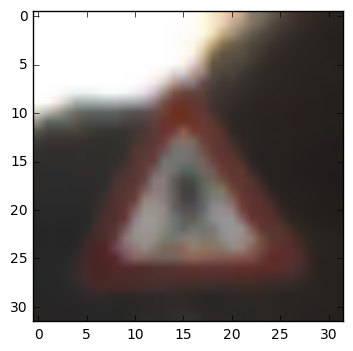

	 Classification =  No passing


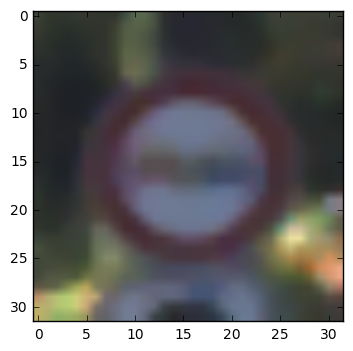

	 Classification =  No passing


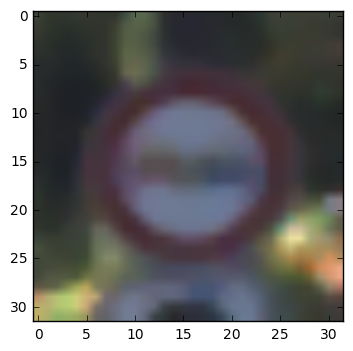

	 Classification =  No passing for vehicles over 3.5 metric tons


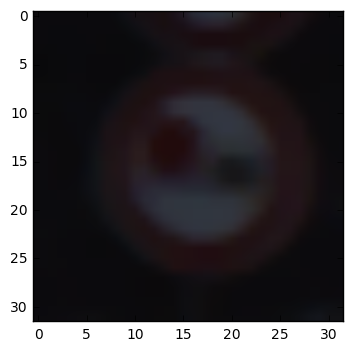

	 Classification =  Keep right


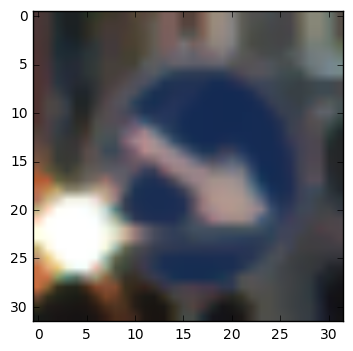

	 Classification =  Ahead only


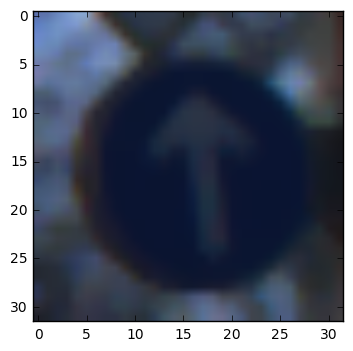

	 Classification =  Pedestrians


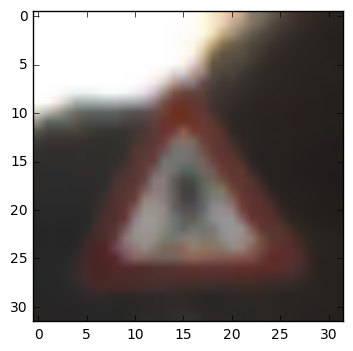

	 Classification =  Ahead only


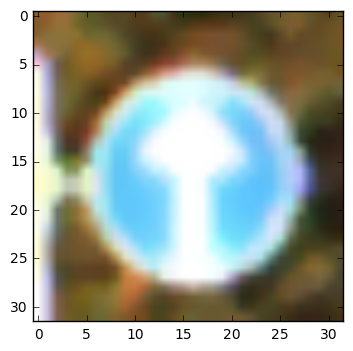

	 Classification =  No vehicles


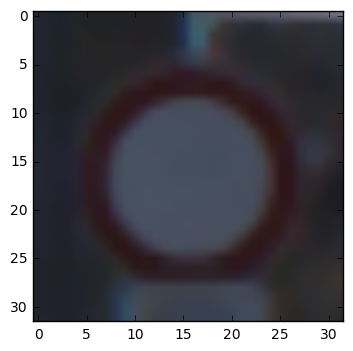

	 Classification =  Yield


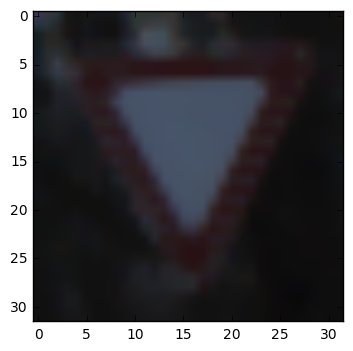

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import cv2
from os import path
from glob import glob
from PIL import Image

from tensorflow.contrib.layers import flatten

img_channels = 3

def featureNormalize(features, meanDiv, stdDiv):
    normFeatures = features.astype('float32')
    normFeatures -= meanDiv
    normFeatures /= stdDiv
    return normFeatures

def load_test_data(img_path):
    col = glob(path.join(path.abspath(img_path), '*.png'))
    imgs = np.ndarray((len(col), 32, 32, img_channels), dtype=np.uint8)
    for idx in range(0, len(col)):
        io = Image.open(col[idx])
        data = io.getdata()
        data_array = np.array(data)
        data_array = data_array.reshape(io.size[0], io.size[1], img_channels)
        imgs[idx] = data_array
    return imgs

# def main_runner():
mu = 0
sigma = 0.1
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (1, 32, 32, 3))

W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
b1 = tf.Variable(tf.zeros(6))
W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
b2 = tf.Variable(tf.zeros(16))
FC1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
FC1_b = tf.Variable(tf.zeros(120))
FC2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
FC2_b = tf.Variable(tf.zeros(84))
FC3_W = tf.Variable(tf.truncated_normal(shape=(84, 84), mean=mu, stddev=sigma))
FC3_b = tf.Variable(tf.zeros(84))
FC4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
FC4_b = tf.Variable(tf.zeros(43))

C1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
C1 = tf.nn.relu(C1)
C1 = tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

C2 = tf.nn.conv2d(C1, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
C2 = tf.nn.relu(C2)
C2 = tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

FC0 = flatten(C2)

FC1 = tf.matmul(FC0, FC1_W) + FC1_b
FC1 = tf.nn.relu(FC1)
# FC1_D = tf.nn.dropout(FC1, 0.9)

FC2 = tf.matmul(FC1, FC2_W) + FC2_b
FC2 = tf.nn.relu(FC2)
# FC2_D = tf.nn.dropout(FC2, 1)

FC3 = tf.matmul(FC2, FC3_W) + FC3_b
FC3 = tf.nn.relu(FC3)
# FC3_D = tf.nn.dropout(FC3, 1)

FC4_Logits = tf.matmul(FC3, FC4_W) + FC4_b

Y_ = tf.nn.softmax(FC4_Logits)

prediction = tf.argmax(Y_, 1)

X_test = load_test_data('./signs')

mean = np.mean(X_test)
std = np.std(X_test)
X_test_X = featureNormalize(X_test, mean, std)

signs = dict()

with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet-signs')
    plt.show()
    for idx in range(0, 10):
        index = random.randint(0, len(X_test_X))
        image = X_test_X[index:index+1]
        xxx = sess.run(prediction, feed_dict={x: image})
        z = str(xxx.item())
        print("======================================================")
        print("\t Classification = ", signs[z])
        plt.imshow(X_test[index])
        plt.show()


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

	 Classification =  Keep right


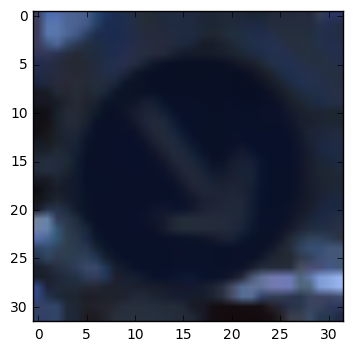

	 Classification =  Double curve


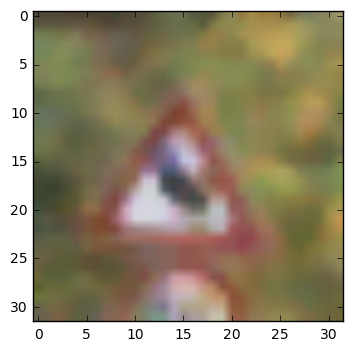

	 Classification =  No passing


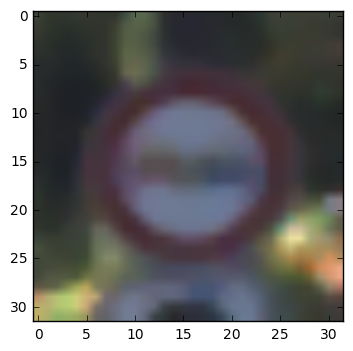

	 Classification =  Speed limit (80km/h)


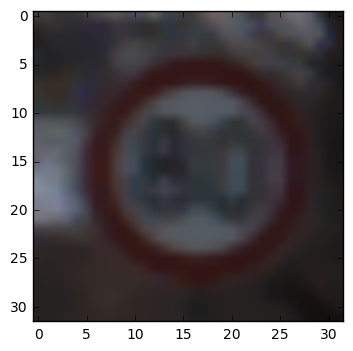

	 Classification =  Speed limit (30km/h)


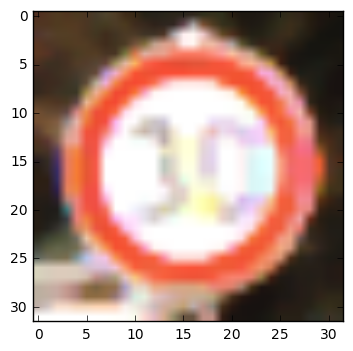

	 Classification =  Double curve


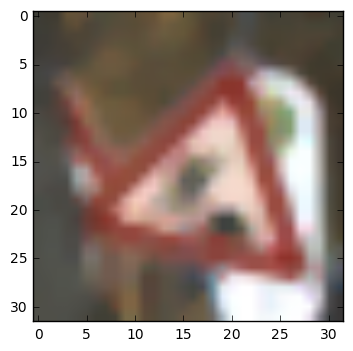

	 Classification =  No passing for vehicles over 3.5 metric tons


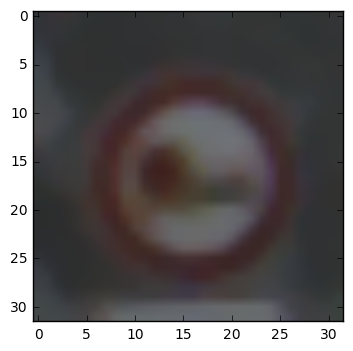

	 Classification =  Speed limit (50km/h)


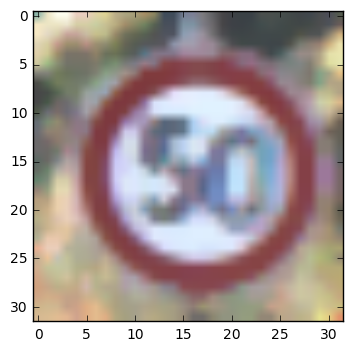

	 Classification =  Ahead only


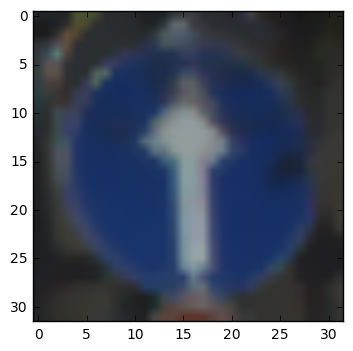

	 Classification =  Double curve


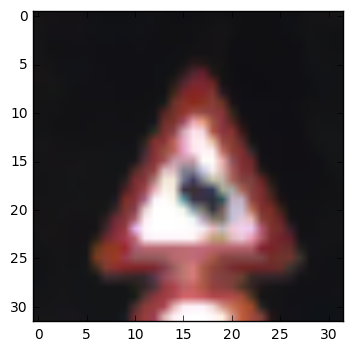

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import cv2
from os import path
from glob import glob
from PIL import Image

from tensorflow.contrib.layers import flatten

img_channels = 3

def featureNormalize(features, meanDiv, stdDiv):
    normFeatures = features.astype('float32')
    normFeatures -= meanDiv
    normFeatures /= stdDiv
    return normFeatures

def load_test_data(img_path):
    col = glob(path.join(path.abspath(img_path), '*.png'))
    imgs = np.ndarray((len(col), 32, 32, img_channels), dtype=np.uint8)
    for idx in range(0, len(col)):
        io = Image.open(col[idx])
        data = io.getdata()
        data_array = np.array(data)
        data_array = data_array.reshape(io.size[0], io.size[1], img_channels)
        imgs[idx] = data_array
    return imgs

# def main_runner():
mu = 0
sigma = 0.1
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (1, 32, 32, 3))

W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
b1 = tf.Variable(tf.zeros(6))
W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
b2 = tf.Variable(tf.zeros(16))
FC1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
FC1_b = tf.Variable(tf.zeros(120))
FC2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
FC2_b = tf.Variable(tf.zeros(84))
FC3_W = tf.Variable(tf.truncated_normal(shape=(84, 84), mean=mu, stddev=sigma))
FC3_b = tf.Variable(tf.zeros(84))
FC4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
FC4_b = tf.Variable(tf.zeros(43))

C1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
C1 = tf.nn.relu(C1)
C1 = tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

C2 = tf.nn.conv2d(C1, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
C2 = tf.nn.relu(C2)
C2 = tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

FC0 = flatten(C2)

FC1 = tf.matmul(FC0, FC1_W) + FC1_b
FC1 = tf.nn.relu(FC1)
# FC1_D = tf.nn.dropout(FC1, 0.9)

FC2 = tf.matmul(FC1, FC2_W) + FC2_b
FC2 = tf.nn.relu(FC2)
# FC2_D = tf.nn.dropout(FC2, 1)

FC3 = tf.matmul(FC2, FC3_W) + FC3_b
FC3 = tf.nn.relu(FC3)
# FC3_D = tf.nn.dropout(FC3, 1)

FC4_Logits = tf.matmul(FC3, FC4_W) + FC4_b

Y_ = tf.nn.softmax(FC4_Logits)

prediction = tf.argmax(Y_, 1)

X_test = load_test_data('./signs')

mean = np.mean(X_test)
std = np.std(X_test)
X_test_X = featureNormalize(X_test, mean, std)

signs = dict()

with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet-signs')
    plt.show()
    for idx in range(0, 10):
        index = random.randint(0, len(X_test_X))
        image = X_test_X[index:index+1]
        xxx = sess.run(prediction, feed_dict={x: image})
        z = str(xxx.item())
        print("======================================================")
        print("\t Classification = ", signs[z])
        plt.imshow(X_test[index])
        plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

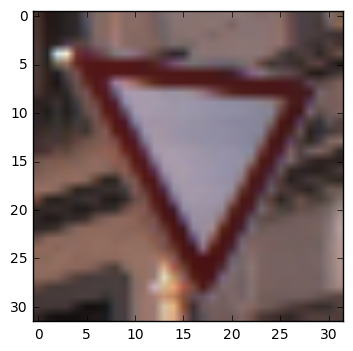

Label= No passing Prediction= No passing
Label= Ahead only Prediction= Ahead only
Label= Yield Prediction= Yield
Label= No entry Prediction= No entry
Label= Pedestrians Prediction= Traffic signals
Label= Road work Prediction= Road work
Label= Speed limit (70km/h) Prediction= Speed limit (70km/h)
Label= End of speed limit (80km/h) Prediction= End of speed limit (80km/h)
Label= Speed limit (30km/h) Prediction= Speed limit (30km/h)
Label= Bicycles crossing Prediction= Bicycles crossing
Accuracy:  90.0 %


In [14]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import cv2
from os import path
from glob import glob
from PIL import Image
import pickle

from tensorflow.contrib.layers import flatten

img_channels = 3

def featureNormalize(features, meanDiv, stdDiv):
    normFeatures = features.astype('float32')
    normFeatures -= meanDiv
    normFeatures /= stdDiv
    return normFeatures

def load_test_data(img_path):
    col = glob(path.join(path.abspath(img_path), '*.png'))
    imgs = np.ndarray((len(col), 32, 32, img_channels), dtype=np.uint8)
    for idx in range(0, len(col)):
        io = Image.open(col[idx])
        data = io.getdata()
        data_array = np.array(data)
        data_array = data_array.reshape(io.size[0], io.size[1], img_channels)
        imgs[idx] = data_array
    return imgs

# def main_runner():
mu = 0
sigma = 0.1
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (1, 32, 32, 3))

W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
b1 = tf.Variable(tf.zeros(6))
W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
b2 = tf.Variable(tf.zeros(16))
FC1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
FC1_b = tf.Variable(tf.zeros(120))
FC2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
FC2_b = tf.Variable(tf.zeros(84))
FC3_W = tf.Variable(tf.truncated_normal(shape=(84, 84), mean=mu, stddev=sigma))
FC3_b = tf.Variable(tf.zeros(84))
FC4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
FC4_b = tf.Variable(tf.zeros(43))

C1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
C1 = tf.nn.relu(C1)
C1 = tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

C2 = tf.nn.conv2d(C1, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
C2 = tf.nn.relu(C2)
C2 = tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

FC0 = flatten(C2)

FC1 = tf.matmul(FC0, FC1_W) + FC1_b
FC1 = tf.nn.relu(FC1)
# FC1_D = tf.nn.dropout(FC1, 0.9)

FC2 = tf.matmul(FC1, FC2_W) + FC2_b
FC2 = tf.nn.relu(FC2)
# FC2_D = tf.nn.dropout(FC2, 1)

FC3 = tf.matmul(FC2, FC3_W) + FC3_b
FC3 = tf.nn.relu(FC3)
# FC3_D = tf.nn.dropout(FC3, 1)

FC4_Logits = tf.matmul(FC3, FC4_W) + FC4_b

Y_ = tf.nn.softmax(FC4_Logits)

prediction = tf.argmax(Y_, 1)

testing_file = './test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_test, y_test = test['features'], test['labels']

mean = np.mean(X_test)
std = np.std(X_test)
X_test_X = featureNormalize(X_test, mean, std)

signs = dict()

with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet-signs')
    plt.show()
    correct = 0
    test_range = 10
    for idx in range(0, 10):
        index = random.randint(0, len(X_test_X))
        image = X_test_X[index:index+1]
        xxx = sess.run(prediction, feed_dict={x: image})
        z = str(xxx.item())
        print("Label=", signs[str(y_test[index])], "Prediction=", signs[z])
        if y_test[index] == int(z):
            correct += 1
        plt.imshow(X_test[index])

    print ("Accuracy: ", (correct/test_range)*100, "%")


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import cv2
from os import path
from glob import glob
from PIL import Image
import pickle

from tensorflow.contrib.layers import flatten

img_channels = 3

def featureNormalize(features, meanDiv, stdDiv):
    normFeatures = features.astype('float32')
    normFeatures -= meanDiv
    normFeatures /= stdDiv
    return normFeatures

def load_test_data(img_path):
    col = glob(path.join(path.abspath(img_path), '*.png'))
    imgs = np.ndarray((len(col), 32, 32, img_channels), dtype=np.uint8)
    for idx in range(0, len(col)):
        io = Image.open(col[idx])
        data = io.getdata()
        data_array = np.array(data)
        data_array = data_array.reshape(io.size[0], io.size[1], img_channels)
        imgs[idx] = data_array
    return imgs

# def main_runner():
mu = 0
sigma = 0.1
tf.reset_default_graph()


x = tf.placeholder(tf.float32, (1, 32, 32, 3))

W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
b1 = tf.Variable(tf.zeros(6))
W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
b2 = tf.Variable(tf.zeros(16))
FC1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
FC1_b = tf.Variable(tf.zeros(120))
FC2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
FC2_b = tf.Variable(tf.zeros(84))
FC3_W = tf.Variable(tf.truncated_normal(shape=(84, 84), mean=mu, stddev=sigma))
FC3_b = tf.Variable(tf.zeros(84))
FC4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
FC4_b = tf.Variable(tf.zeros(43))

C1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
C1 = tf.nn.relu(C1)
C1 = tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

C2 = tf.nn.conv2d(C1, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
C2 = tf.nn.relu(C2)
C2 = tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

FC0 = flatten(C2)

FC1 = tf.matmul(FC0, FC1_W) + FC1_b
FC1 = tf.nn.relu(FC1)
# FC1_D = tf.nn.dropout(FC1, 0.9)

FC2 = tf.matmul(FC1, FC2_W) + FC2_b
FC2 = tf.nn.relu(FC2)
# FC2_D = tf.nn.dropout(FC2, 1)

FC3 = tf.matmul(FC2, FC3_W) + FC3_b
FC3 = tf.nn.relu(FC3)
# FC3_D = tf.nn.dropout(FC3, 1)

FC4_Logits = tf.matmul(FC3, FC4_W) + FC4_b

Y_ = tf.nn.softmax(FC4_Logits)
certainty = tf.nn.top_k(Y_, k=3)
prediction = tf.argmax(Y_, 1)

testing_file = './test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_test, y_test = test['features'], test['labels']

mean = np.mean(X_test)
std = np.std(X_test)
X_test_X = featureNormalize(X_test, mean, std)

signs = dict()

with open('./signnames.csv', newline='') as csvfile:
    fieldnames = ['ClassId', 'SignName']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        if row['ClassId'] == 'ClassId': continue
        signs[row['ClassId']] = row['SignName']

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet-signs')
    correct = 0
    test_range = 10
    for idx in range(0, 10):
        index = random.randint(0, len(X_test_X))
        image = X_test_X[index:index+1]
        xxx = sess.run(prediction, feed_dict={x: image})
        c = sess.run(certainty, feed_dict={x: image})
        z = str(xxx.item())
        print("Label=", signs[str(y_test[index])], "Prediction=", signs[z], "Index=", z, "\nCertainty=", c)
        if y_test[index] == int(z):
            correct += 1


Label= Priority road Prediction= Priority road Index= 12 
Certainty= TopKV2(values=array([[  1.00000000e+00,   4.13336990e-17,   2.49037070e-19]], dtype=float32), indices=array([[12, 42, 11]]))
Label= Yield Prediction= Yield Index= 13 
Certainty= TopKV2(values=array([[  9.99985695e-01,   1.42692197e-05,   5.21779810e-08]], dtype=float32), indices=array([[13, 10,  9]]))
Label= End of speed limit (80km/h) Prediction= No vehicles Index= 15 
Certainty= TopKV2(values=array([[ 0.71133798,  0.14200892,  0.07708867]], dtype=float32), indices=array([[15, 36, 28]]))
Label= Priority road Prediction= Priority road Index= 12 
Certainty= TopKV2(values=array([[  1.00000000e+00,   7.50109881e-14,   3.38351953e-14]], dtype=float32), indices=array([[12, 10, 42]]))
Label= Speed limit (80km/h) Prediction= Speed limit (80km/h) Index= 5 
Certainty= TopKV2(values=array([[  9.57919598e-01,   4.19573262e-02,   1.12265559e-04]], dtype=float32), indices=array([[5, 3, 2]]))
Label= Right-of-way at the next interse